In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image,ImageFilter
import twl

def showimage(img,x):

    plt.axis("off")
    if(x==0):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif(x==1):
        plt.imshow(img)
    else:
        plt.imshow(img,cmap='gray')
    plt.show()


# Gamma Transformation

In [ ]:
def gammaTransform(im,y):

    im=im.astype(float)
    im=im/255
    im=np.power(im,y)
    im=im*255

    im=im.astype(np.uint8)

    return im




# Contrast Stretching

In [ ]:
def linContrastStretching(quantum):
    a=0
    b=255

    x=np.max(quantum,axis=0)


    x=np.max(x,axis=0)

    y=np.min(quantum ,axis=0)
    y=np.min(y,axis=0)

    quantum=quantum.astype(float)
    for i in range(len(quantum)):
        for j in range(len(quantum[0])):
            quantum[i][j][0]=a+(quantum[i][j][0]-y[0])*(b-a)/(x[0]-y[0])
            quantum[i][j][1]=a+(quantum[i][j][1]-y[1])*(b-a)/(x[1]-y[1])
            quantum[i][j][2]=a+(quantum[i][j][2]-y[2])*(b-a)/(x[2]-y[2])
    quantum=quantum.astype(np.uint8)
    x=np.max(quantum,axis=0)


    x=np.max(x,axis=0)

    y=np.min(quantum ,axis=0)
    y=np.min(y,axis=0)

    return quantum

# Perspective Skew Correction

In [ ]:
def si(img):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

def bgr_to_rgb(images):
    RGB_images = []
    for image in images:
        RGB_images.append(image[..., ::-1])
    return RGB_images

def get_contour(img):
    # Return the largest contour
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey, (7, 7), 0)
    edges = cv2.Canny(blur, 50, 100, apertureSize=3)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations=2)
    img1,contours, hierarchy = cv2.findContours(
        dilation,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    contour_img = img.copy()
    # Draws the  largest contour
    contour_img = cv2.drawContours(contour_img, [cnt], 0, (0, 255, 0), 3)
    return contour_img, cnt

def get_points(cnt):
    # Return the co-ordinates of the contour corner
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    x_center = np.mean(approx[:, :, 0])
    y_center = np.mean(approx[:, :, 1])

    # sorting
    pts = np.zeros((4, 2))
    for x in approx:
        for X, Y in x:
            if X < x_center and Y < y_center:
                pts[0, 0] = X
                pts[0, 1] = Y
            if X < x_center and Y > y_center:
                pts[1, 0] = X
                pts[1, 1] = Y
            if X > x_center and Y > y_center:
                pts[2, 0] = X
                pts[2, 1] = Y
            if X > x_center and Y < y_center:
                pts[3, 0] = X
                pts[3, 1] = Y
    size = max(approx.flatten()) - min(approx.flatten())
    return pts, size

def warp_image(img, pts, size):

    pts = np.float32(pts)
    pts_sqr = np.float32([[0, 0], [0, size], [size, size], [size, 0]])
    M = cv2.getPerspectiveTransform(pts, pts_sqr)
    warped_img = cv2.warpPerspective(img, M, (size, size))
    return warped_img



def get_slices(img):

    contour_img, cnt = get_contour(img)
    showimage(contour_img,1)
    pts, size = get_points(cnt)
    board = warp_image(img, pts, size)
    warped_img = board[..., ::-1]


    return warped_img

# 8-way Component

In [ ]:


def find(parent,i):

    if(parent[i]==-1):
        return parent,i
    parent,parent[i]= find(parent,parent[i])
    return parent,parent[i]


def union(parent,u,v):

    parent,x=find(parent,u)
    parent,y=find(parent,v)

    if(x==y):
        return parent
    if(x<y):
        parent[y]=x
    else:
        parent[x]=y

    return parent

def component(im):
    im=im&1
    color=np.zeros([im.shape[0],im.shape[1]],dtype=int)
    index=1

    for i in range(len(im)):
        for j in range(len(im[0])):
            if(im[i][j]==0):
                continue

            ans=1000000000

            # Checking if any of the 8 neighnour of a pixel have been assigned a number and if yes then finding the min amoong the 8 possible neighbour

            if(i-1>=0 and color[i-1][j]>0  ):
                ans=min(ans,color[i-1][j])
            if(j-1>=0 and color[i][j-1]>0  ):
                ans=min(ans,color[i][j-1])
            if(j+1<len(im[0]) and color[i][j+1]>0  ):
                ans=min(ans,color[i][j+1])
            if(i+1<len(im) and color[i+1][j]>0  ):
                ans=min(ans,color[i+1][j])
            if(i-1>=0 and j-1>=0 and color[i-1][j-1]>0):
                ans=min(ans,color[i-1][j-1])
            if(i-1>=0 and j+1<len(im[0]) and color[i-1][j+1]>0):
                ans=min(ans,color[i-1][j+1])
            if( i+1<len(im) and j-1>=0 and color[i+1][j-1]>0):
                ans=min(ans,color[i+1][j-1])
            if( i+1<len(im) and j+1<len(im[0]) and color[i+1][j+1]>0):
                ans=min(ans,color[i+1][j+1])



            if(ans!=1000000000):
                color[i][j]=ans

            else:
                color[i][j]=index
                index+=1


    parent=np.empty(index+1,dtype=int)
    parent.fill(-1)

    # For a pixel we check it's 8 neighbour if any of them have been assigned a different number then we join them to find a common parent
    for i in range(len(im)):
        for j in range(len(im[0])):
            if(im[i][j]==0):
                continue
            if(i-1>=0 and color[i-1][j]>0  ):
                x1=min(color[i][j],color[i-1][j])
                x2=max(color[i][j],color[i-1][j])
                parent=union(parent,x1,x2)
            if(j-1>=0 and color[i][j-1]>0  ):
                x1=min(color[i][j],color[i][j-1])
                x2=max(color[i][j],color[i][j-1])
                parent=union(parent,x1,x2)
            if(j+1<len(im[0]) and color[i][j+1]>0  ):
                x1=min(color[i][j],color[i][j+1])
                x2=max(color[i][j],color[i][j+1])
                parent=union(parent,x1,x2)
            if(i+1<len(im) and color[i+1][j]>0  ):
                x1=min(color[i][j],color[i+1][j])
                x2=max(color[i][j],color[i+1][j])
                parent=union(parent,x1,x2)
            if(i-1>=0 and j-1>=0 and color[i-1][j-1]>0):
                x1=min(color[i][j],color[i-1][j-1])
                x2=max(color[i][j],color[i-1][j-1])
                parent=union(parent,x1,x2)
            if(i-1>=0 and j+1<len(im[0]) and color[i-1][j+1]>0):
                x1=min(color[i][j],color[i-1][j+1])
                x2=max(color[i][j],color[i-1][j+1])
                parent=union(parent,x1,x2)
            if( i+1<len(im) and j-1>=0 and color[i+1][j-1]>0):
                x1=min(color[i][j],color[i+1][j-1])
                x2=max(color[i][j],color[i+1][j-1])
                parent=union(parent,x1,x2)
            if( i+1<len(im) and j+1<len(im[0]) and color[i+1][j+1]>0):
                x1=min(color[i][j],color[i+1][j+1])
                x2=max(color[i][j],color[i+1][j+1])
                parent=union(parent,x1,x2)

    for i in range(len(color)):
        for j in range(len(color[0])):
            if(color[i][j]>0):
                parent,color[i][j]=find(parent,color[i][j])


    return color


# Character Recognition

In [ ]:
def checkI(img):
    chk_x=img.shape[0]
    chk_y=img.shape[1]
    mn_col=chk_y
    mx_col=0
    mn_row=chk_x
    mx_row=0
    # Finding the upper ,lower ,left and right boundary coordinate
    for i in range(chk_x):
        for j in range(chk_y):
            if(img[i][j]==255):
                mn_col=min(mn_col,j)
                mx_col=max(mx_col,j)
                mn_row=min(mn_row,i)
                mx_row=max(mx_row,i)
    # Calculating number of white pixel
    count1=0
    for i in range(mn_row,mx_row+1):
        for j in range(mn_col,mx_col+1):
            if(img[i][j]==255):
                count1+=1
    col1=mx_col-mn_col
    row1=mx_row-mn_row
    cells = (row1+1)*(col1+1)
    # Checking if number of white cell expands more in vertical direction than horizontal direction
    if(3*col1>= row1):
        return False
    else:
        # Checking if major part of the region is filled with white pixel
        if(6*cells <= 10*count1):
            return True
        else:
            return False




def grid_cell(img ,x):


    showimage(img,0)


    side_x=img.shape[1]/30
    side_x=int(side_x)
    side_y=img.shape[0]/30
    side_y=int(side_y)
    pt=[side_y,side_x]
    counter=0

    matrix=np.empty([15,15],dtype=str)
    matrix.fill("_")

    for i in range(15):
        for j in range(15):

            # Cropping the cell from the grid
            temp=img[pt[0]-x//2:pt[0]+x//2,pt[1]-x//2:pt[1]+x//2]

            # Blurring for better thresholding
            temp = cv2.GaussianBlur(temp,(3,3),cv2.BORDER_DEFAULT)


            # Contrast stretching
            temp=linContrastStretching(temp)


            temp=cv2.cvtColor(temp,cv2.COLOR_RGB2GRAY)


            # Histogram Equalization
            temp = cv2.equalizeHist(temp)



            # Thresholding so that letter comes in foreground and other's in background
            ret,thresh = cv2.threshold(temp,25,255,cv2.THRESH_BINARY)
            thresh=255-thresh

            #  using 8-way component function to find the biggest component assuming the letter will form the biggest component
            thresh=thresh.astype(int)
            thresh=thresh/255
            thresh=thresh.astype(np.uint8)
            color=component(thresh)
            store=[]
            # Finding all the distinct label
            for index1 in color:
                for index2 in index1:
                    if index2>0 and index2 not in store:
                        store.append(index2)
            m1=0
            m2=0
            # Finding label with max white pixel
            for index in store:
                no=np.count_nonzero(color==index)
                if no>m1:
                    m1=no
                    m2=index

            temp=np.zeros([color.shape[0],color.shape[1]],dtype=np.uint8)
            for index1 in range(len(temp)):
                for index2 in range(len(temp[0])):
                    if color[index1][index2]==m2:
                        temp[index1][index2]=255





            # Tesseract for OCR
            data = pytesseract.image_to_string(255-temp,config='-c tessedit_char_whitelist=|0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')

            # Doing further processing only if
            if data[0]=='0' or (data[0]>="A" and data[0]<="Z")  :

                if data[0]=='0':
                    matrix[i][j]="O"
                # Observed that most of the noise was due to following character   so further proccessing
                elif data[0]=="J" or data[0]=="T" or data[0]=="C" or data[0]=="Z" or data[0]=="D":
                    # Erode to  remove noise and then check again if we get the same character using tysseract
                    kernel = np.ones((2, 2), np.uint8)
                    thresh = cv2.erode(temp, kernel)
                    new_data=pytesseract.image_to_string(255-thresh,config='-c tessedit_char_whitelist=0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')
                    if(new_data[0]==data[0]):
                        matrix[i][j]=data[0]


                else:

                    if data[0]=="L":
                        kernel = np.ones((3, 3), np.uint8)
                        thresh = cv2.erode(temp, kernel)
                        new_data=pytesseract.image_to_string(255-thresh,config='-c tessedit_char_whitelist=0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')

                        if new_data[0]=="L" and len(new_data)==3 and ord(new_data[1])==10 and ord(new_data[2])==12:
                            matrix[i][j]="L"
                    elif data[0]=="I":
                        continue
                    else:
                        matrix[i][j]=data[0]

            # Only for I bcoz pytesseract is unable to recognize I
            elif checkI(temp)==True:
                matrix[i][j]="I"
                # Removing if white pixel are at any edge
                edger_fg=0
                edgec_fg=0
                chk_x=temp.shape[0]
                chk_y=temp.shape[1]

                for i1 in range(chk_y):
                    if(temp[0][i1]==255):
                        edger_fg+=1
                    if(temp[chk_x-1][i1]==255):
                        edger_fg+=1
                for i1 in range(chk_x):
                    if(temp[i1][0]==255):
                        edgec_fg+=1
                    if(temp[i1][chk_y-1]==255):
                        edgec_fg+=1
                if(edger_fg!=0 or edgec_fg!=0):
                    matrix[i][j]="_"
            #Removing  a component if it touch more than one edge
            edger_fg=0
            edgec_fg=0
            chk_x=temp.shape[0]
            chk_y=temp.shape[1]
            for i1 in range(chk_y):
                if(temp[0][i1]==255):
                    edger_fg+=1
                if(temp[chk_x-1][i1]==255):
                    edger_fg+=1
            for i1 in range(chk_x):
                if(temp[i1][0]==255):
                    edgec_fg+=1
                if(temp[i1][chk_y-1]==255):
                    edgec_fg+=1
            if(edger_fg!=0 and edgec_fg!=0):
                matrix[i][j]="_"

            pt[1]+=2*side_x
            counter+=1
        pt[0]+=2*side_y
        pt[1]=side_x

    # Removing character from matrix if it's 4 neighbour are empty
    for i in range(15):
        for j in range(15):
            if(matrix[i][j]!="_"):
                count1=0
                if(i>0 and matrix[i-1][j]!="_"):
                    count1+=1
                if(i<14 and matrix[i+1][j]!="_"):
                    count1+=1
                if(j>0 and matrix[i][j-1]!="_"):
                    count1+=1
                if(j<14 and matrix[i][j+1]!="_"):
                    count1+=1

                if(count1==0):
                    matrix[i][j]="_"

    print(matrix)



# Top scoring words

In [ ]:
WORDS = set(twl.iterator())


LETTER_SCORES = {"a": 1, "b": 3, "c": 3, "d": 2,
                 "e": 1, "f": 4, "g": 2, "h": 4,
                 "i": 1, "j": 8, "k": 5, "l": 1,
                 "m": 3, "n": 1, "o": 1, "p": 3,
                 "q": 10, "r": 1, "s": 1, "t": 1,
                 "u": 1, "v": 4, "w": 4, "x": 8,
                 "y": 4, "z": 10}

In [ ]:
def crop(loc):
    '''To crop the image to obtain just the alphabets using contours'''
    img = cv2.imread(loc)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]
    img1,contours , hierarchy = cv2.findContours(thresh, 1, 2)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w>280 and h>40:
            break
    cropped = img[y:y+h, x:x+w]
    cv2.imwrite('crop_tiles.jpg',255 - cropped)
    return cropped


def get_letters(loc):
    '''To obtain the letters with the cropped image as the input'''
    img = Image.open (loc).convert('L')
    blackwhite = img.point(lambda x: 255 if x < 166 else 0, '1')
    blackwhite.save("tiles_bw.jpg")
    im = Image.open("tiles_bw.jpg")
    smooth_im = im.filter(ImageFilter.SMOOTH_MORE)
    smooth_im = np.asarray(smooth_im)
    kernel = np.ones((3,3),np.uint8)
    smooth_im = cv2.erode(smooth_im,kernel,iterations = 1)
    plt.imshow(smooth_im,cmap = 'gray')
    plt.show()
    text = pytesseract.image_to_string(smooth_im, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 7')
    letters = text.lower()
    letter_list = [x for x in letters]
    print("Letters Are: " + letters)
    return letter_list

def check_valid_words(current_tile_letters, scrabble_words):
    '''With the obtained alphabets , verifying the valid words
    which are there in the TWL Library'''
    temp_word_array = []

    for word in scrabble_words:
        for letter in word:
            if letter not in current_tile_letters:
                break
            elif word.count(letter) > current_tile_letters.count(letter):
                break
        else:
            temp_word_array.append(word)
            continue
    temp_word_array.sort()
    return temp_word_array

def get_top_scoring_words(valid_words):
    '''From the obtained words, getting the words based on the score'''
    word_and_score = dict()

    for word in valid_words:
        score = 0
        for letter in word:
            score += LETTER_SCORES.get(letter)
        word_and_score[word] = score

    return dict(sorted(word_and_score.items(), key=lambda x: x[1], reverse=True)[:10])

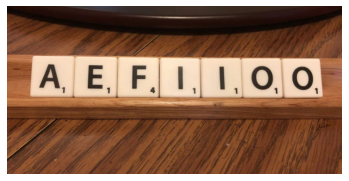

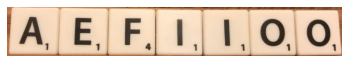

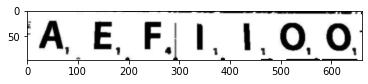

Letters Are: ‘a, e, fj 1, 1,0,0,

{'ef': 5, 'fa': 5, 'fe': 5, 'ae': 2}


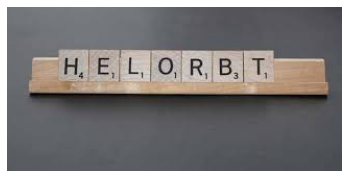

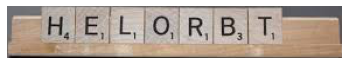

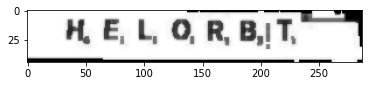

Letters Are: helorbit |

{'blither': 12, 'brothel': 12, 'blithe': 11, 'bother': 11, 'berth': 10, 'birth': 10, 'brith': 10, 'broth': 10, 'throb': 10, 'beth': 9}


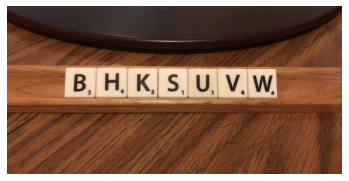

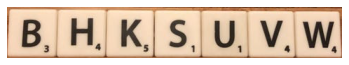

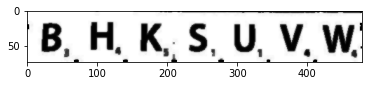

Letters Are: 'b, hk. s. u, v.w.

{'husk': 11, 'busk': 10, 'bush': 9, 'hubs': 9, 'hub': 8, 'suk': 7, 'bus': 5, 'sh': 5, 'sub': 5, 'uh': 5}


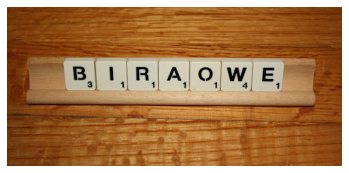

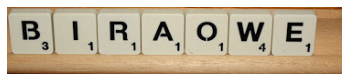

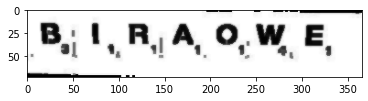

Letters Are: by 1a a, ow, e

{'away': 10, 'yowe': 10, 'abye': 9, 'obey': 9, 'way': 9, 'wye': 9, 'yaw': 9, 'yew': 9, 'yow': 9, 'aby': 8}


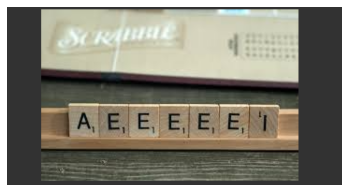

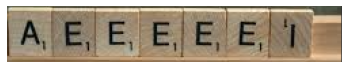

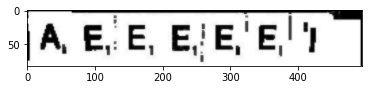

Letters Are: |a, ££, 66,6! 4

{}


In [ ]:
scrabble_words = WORDS
for i in range(1,6):
    loc = '../images/tiles7/' + str(i)+'.jpeg'
    im = cv2.imread(loc)
    showimage(im,0)
    cr = crop(loc)
    showimage(cr,0)
    current_tile_letters = get_letters('crop_tiles.jpg')
    valid_words = check_valid_words(current_tile_letters, scrabble_words)
    top_word_scores = get_top_scoring_words(valid_words)
    print(top_word_scores)

# Main

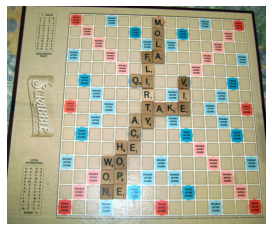

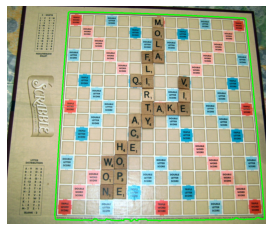

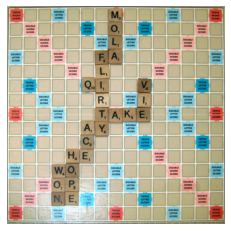

[['_' '_' '_' '_' '_' '_' '_' 'M' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' 'O' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' 'L' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'F' 'A' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'L' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' 'Q' 'I' '_' '_' 'V' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'R' '_' '_' 'I' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' 'T' 'A' 'K' 'E' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' 'A' 'Y' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' 'C' '_' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'H' 'E' '_' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'W' 'O' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'O' 'P' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' 'N' 'E' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_' '_']]


In [ ]:

def input(strg)

    img=cv2.imread(strg)
    showimage(img,0)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=get_slices(img)

    # To calculate the approx side of each cell
    area=img.shape[0]*img.shape[1]
    area=(95*area)/100
    area=area/225
    x=np.sqrt(area)
    x=int(x)


    grid_cell(img,x)




In [ ]:
input('./../images/board1/jpg')